# DÉTERMINATION ÉVOLUTION SIMPLE DU STRETCH

## Modules à importer

In [21]:
import math
import scipy
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from scipy.stats import poisson
from sklearn.cluster import KMeans
from variaIa.variaIa import baserate
from variaIa.variaIa import stretchevol
import matplotlib.pyplot as plt
import random

## Définition des dictionnaires généraux : $z_{\text{max}}$, $z[:z_{\text{max}}]$, $x_1[:z_{\text{max}}]$, LsSFR, stretch, erreurs et Py

In [11]:
d_snf = pd.read_csv('../Data/lssfr_paper_full_sntable.csv',sep=',')

zmax = {'SDSS': 0.22,
        'SNLS': 0.70,
        'PS1': 0.33,
        'HST': 10,
        'SNF': 10}

zmax_cuts = dict()
z_zcuts = dict()
x1_zcuts = dict()
x1_err_zcuts = dict()
    
zmax_cuts['SNF'] = np.where(d_snf['host.zcmb'].values < zmax['SNF'])
z_zcuts['SNF'] = d_snf['host.zcmb'].values[zmax_cuts['SNF']]
x1_zcuts['SNF'] = d_snf['salt2.X1'].values[zmax_cuts['SNF']]
x1_err_zcuts['SNF'] = d_snf['salt2.X1.err'].values[zmax_cuts['SNF']]

lssfr = dict()
lssfr_err_d = dict()
lssfr_err_u = dict()
x1_err = dict()
py = dict()

lssfr_med = -10.82

survey = 'SNF'

lssfr[survey] = d_snf['lssfr'].values
lssfr_err_d[survey] = d_snf['lssfr.err_down'].values
lssfr_err_u[survey] = d_snf['lssfr.err_up'].values
x1_err[survey] = d_snf['salt2.X1.err'].values
py[survey] = d_snf['p(prompt)'].values

## Définition dictionnaires spécifiques : lssfr et stretch young/old simple

In [12]:
d_snf_y = d_snf.loc[d_snf['lssfr']>lssfr_med]
lssfr_y = d_snf_y['lssfr']
x1_y = d_snf_y['salt2.X1']
x1_y_err = d_snf_y['salt2.X1.err']

d_snf_o = d_snf.loc[d_snf['lssfr']<lssfr_med]
lssfr_o = d_snf_o['lssfr']
x1_o = d_snf_o['salt2.X1']
x1_o_err = d_snf_o['salt2.X1.err']

## Définition du modèle à minimiser et minimisation

In [13]:
def gauss(x, dx, mu, sigma):
    return scipy.stats.norm.pdf(x, mu, scale=np.sqrt(dx**2+sigma**2))

def loglikelihood_y(mu_y, sigma_y):
    return -2*np.sum(np.log(gauss(x1_y, x1_y_err, mu_y, sigma_y)))

def loglikelihood_o(mu_o, sigma_o):
    return -2*np.sum(np.log(gauss(x1_o, x1_o_err, mu_o, sigma_o)))

m_y = im.Minuit(loglikelihood_y, mu_y=0, sigma_y=1,
                print_level=0, pedantic=False)
m_o = im.Minuit(loglikelihood_o, mu_o=0, sigma_o=1,
                print_level=0, pedantic=False)

m_y.migrad()
m_o.migrad();

## Tracé de $x_1$ en fonction du $LsSFR$ pour SNF

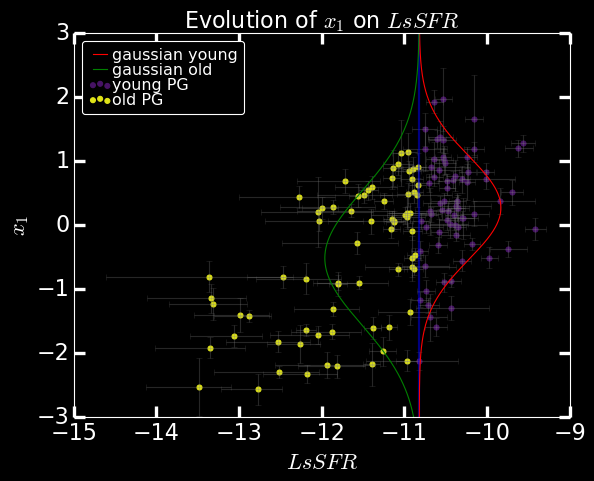

In [20]:
plt.style.use(['classic', 'dark_background'])
#plt.style.use('seaborn-white')

plt.scatter(lssfr_y, x1_y, marker = 'o', s = 20,
            color = plt.cm.viridis(0.05, 1), label='young PG')
plt.scatter(lssfr_o, x1_o, marker = 'o', s = 20,
            color = plt.cm.viridis(0.95, 1), label='old PG')

plt.errorbar(lssfr['SNF'], x1_zcuts['SNF'],
             xerr = [lssfr_err_d['SNF'], lssfr_err_u['SNF']],
             yerr = x1_err['SNF'],
             ecolor = 'gray',
             alpha = .3,
             ls='none')

plt.plot([lssfr_med,lssfr_med], [-3,3], color = 'b', alpha = .5, linewidth=2.0)

x_linspace = np.linspace(-3,3,1000)

plt.plot(2*gauss(x_linspace, 0, m_y.values['mu_y'], m_y.values['sigma_y'])+lssfr_med,
         x_linspace, color = 'r', label='gaussian young')
plt.plot(-3*gauss(x_linspace, 0, m_o.values['mu_o'], m_o.values['sigma_o'])+lssfr_med,
         x_linspace, color = 'g', label='gaussian old')

ax = plt.gca()

ax.tick_params(axis = 'both',
               direction = 'in',
               length = 10, width = 3,
               labelsize = 20,
               which = 'both',
               top = True, right = True)
ax.set_ylim([-3,3])
plt.xlabel('$LsSFR$', fontsize = 20)
plt.ylabel('$x_1$', fontsize = 20)

plt.legend(ncol=1, loc='upper left', 
           #bbox_to_anchor=[0.5, 1.1], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=True, shadow=True)

plt.title('Evolution of $x_1$ on $LsSFR$', fontsize = 20)

plt.show()

## Utilisation de la classe $stretchevol$ pour un fit simple du stretch

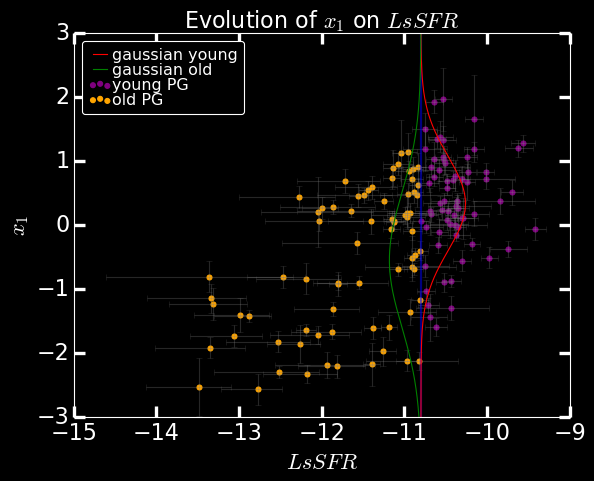

In [67]:
reload(stretchevol)

names = {'lssfr_name':       'lssfr',
         'stretch_name':     'salt2.X1',
         'stretch_err_name': 'salt2.X1.err',
         'lssfr_err_d_name': 'lssfr.err_down',
         'lssfr_err_u_name': 'lssfr.err_up'}

evol = stretchevol.EvolSimple()
evol.set_names(names)
evol.set_data(d_snf)

evol.minimize()

evol.plt_scatter()

## Détermination deux nuages

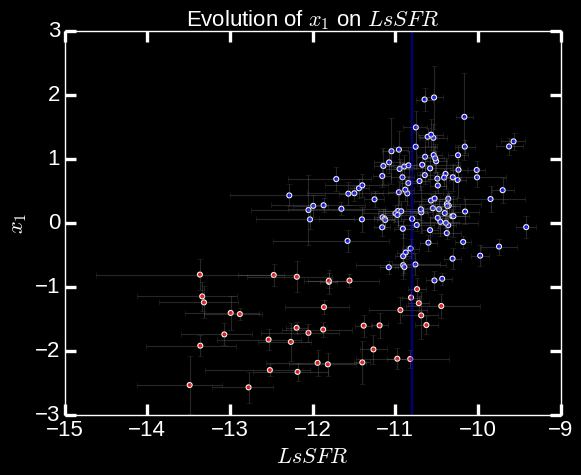

In [94]:
nuage = np.array([lssfr['SNF'], x1_zcuts['SNF']]).T

km = KMeans(2)
km.fit(nuage)

cmap = plt.cm.get_cmap("bwr", km.cluster_centers_.shape[0])
km_colors = [cmap(i) for i in km.fit_predict(nuage)]

plt.style.use('dark_background')
#plt.style.use('seaborn-white')

fig, ax = plt.subplots(1, 1)

ax.scatter(nuage[:, 0], nuage[:, 1], c=km_colors)

ax.errorbar(lssfr['SNF'], x1_zcuts['SNF'],
            xerr = [lssfr_err_d['SNF'], lssfr_err_u['SNF']],
            yerr = x1_err['SNF'],
            ecolor = 'gray',
            alpha = .3,
            ls='none')

plt.plot([lssfr_med,lssfr_med], [-3,3], color = 'b', alpha = .5, linewidth=2.0)

ax.tick_params(axis = 'both',
               direction = 'in',
               length = 10, width = 3,
               labelsize = 20,
               which = 'both',
               top = True, right = True)
ax.set_ylim([-3,3])
plt.xlabel('$LsSFR$', fontsize = 20)
plt.ylabel('$x_1$', fontsize = 20)

plt.title('Evolution of $x_1$ on $LsSFR$', fontsize = 20)

plt.show()

red_loc = np.array([bool(i) for i in km.fit_predict(nuage)])
blue_loc = np.array([not i for i in red_loc])

better_lssfr_y = lssfr['SNF'][blue_loc][lssfr['SNF'][blue_loc]>lssfr_med]
better_x1_y    = x1_zcuts['SNF'][blue_loc][lssfr['SNF'][blue_loc]>lssfr_med]